# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
import os

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [4]:
train_ds= keras.utils.image_dataset_from_directory(
    "New Plant Diseases Dataset(Augmented)/train",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 70295 files belonging to 38 classes.


In [5]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 38)


In [6]:
class_names = train_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [7]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
print("Total batches:", total_batches)


total_images = total_batches * 32  
print("Estimated total images:", total_images)

Total batches: 2197
Estimated total images: 70304


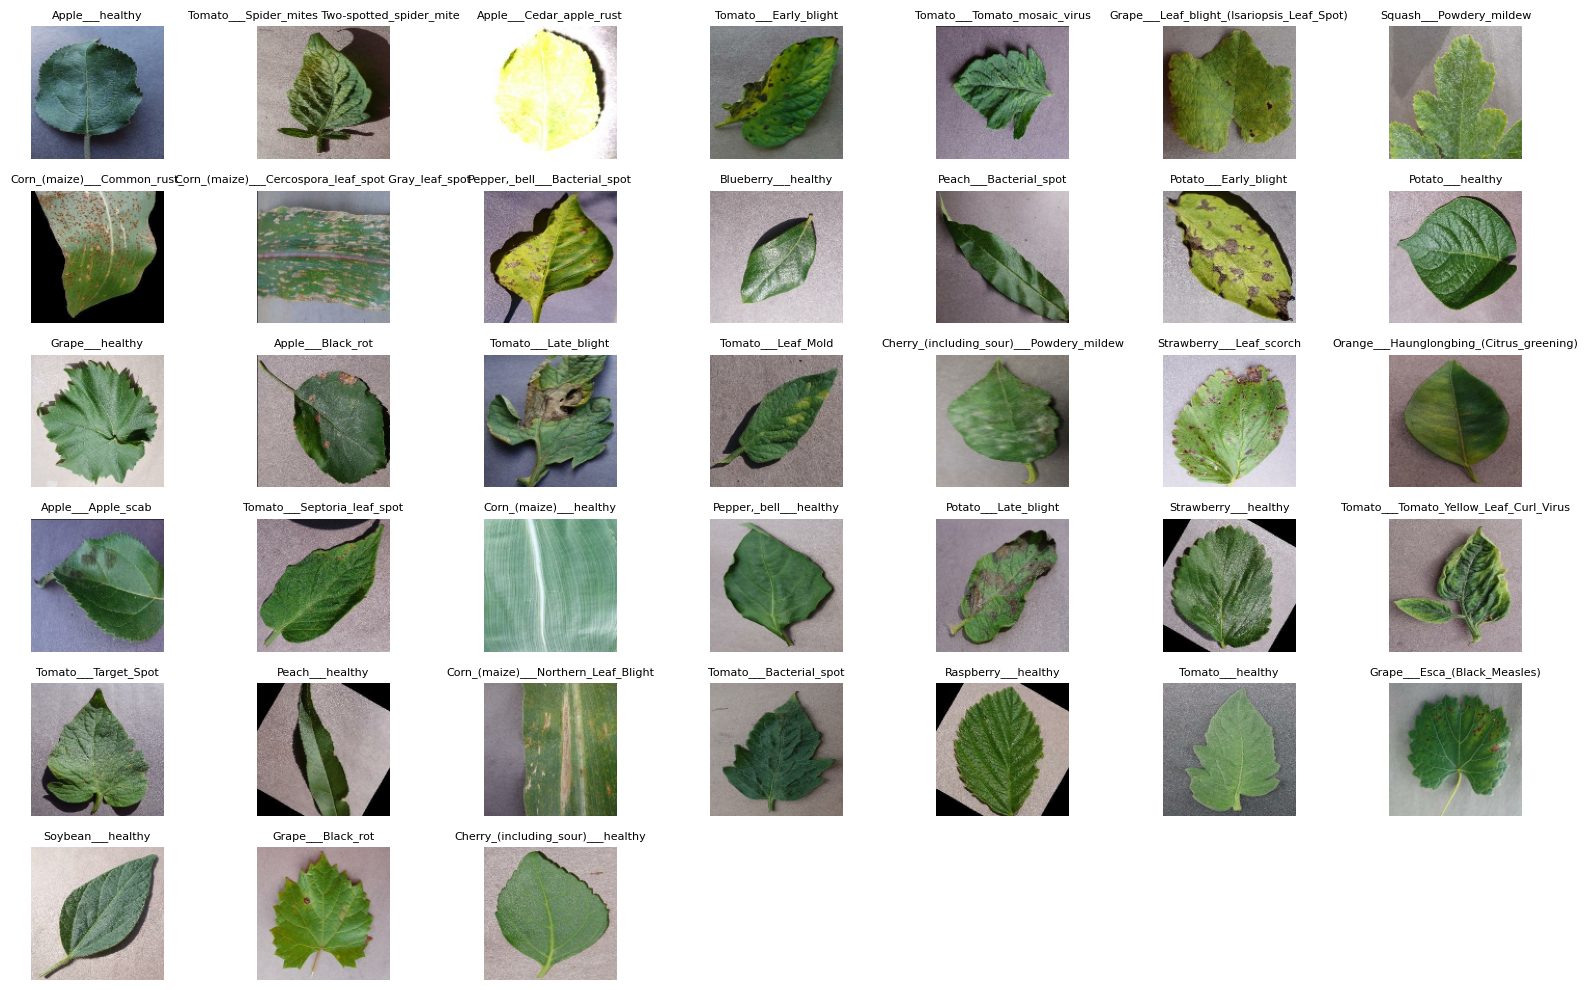

In [8]:
shown = set()
plt.figure(figsize=(16, 10))
i = 0

for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_idx = np.argmax(label.numpy())
        if class_idx not in shown:
            shown.add(class_idx)
            plt.subplot(6, 7, i + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(train_ds.class_names[class_idx], fontsize=8)
            plt.axis("off")
            i += 1
        if len(shown) == len(train_ds.class_names):
            break
    if len(shown) == len(train_ds.class_names):
        break

plt.tight_layout()
plt.show()

In [9]:
valid_ds= keras.utils.image_dataset_from_directory(
    "New Plant Diseases Dataset(Augmented)/valid",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

In [12]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

# Building a Model

In [15]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [16]:
model = Sequential()

In [17]:
model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", activation= "relu", input_shape=[128,128,3]))
model.add(Conv2D(filters = 32, kernel_size = 3, activation= "relu"))
model.add(MaxPool2D(pool_size=2, strides=2))

In [18]:
model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same", activation= "relu"))
model.add(Conv2D(filters = 64, kernel_size = 3, activation= "relu"))
model.add(MaxPool2D(pool_size=2, strides=2))

In [19]:
model.add(Conv2D(filters = 128, kernel_size = 3, padding = "same", activation= "relu"))
model.add(Conv2D(filters = 128, kernel_size = 3, activation= "relu"))
model.add(MaxPool2D(pool_size=2, strides=2))

In [20]:
model.add(Conv2D(filters = 256, kernel_size = 3, padding = "same", activation= "relu"))
model.add(Conv2D(filters = 256, kernel_size = 3, activation= "relu"))
model.add(MaxPool2D(pool_size=2, strides=2))

In [21]:
model.add(Conv2D(filters = 512, kernel_size = 3, padding = "same", activation= "relu"))
model.add(Conv2D(filters = 512, kernel_size = 3, activation= "relu"))
model.add(MaxPool2D(pool_size=2, strides=2))

In [22]:
model.add(Dropout(0.25))

In [23]:
model.add(Flatten())

In [24]:
model.add(Dense(units = 1500,activation = "relu"))

In [25]:
model.add(Dropout(0.4))

In [26]:
model.add(Dense(units = 38,activation = "softmax"))

# Compiling the Model

In [27]:
model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss = "categorical_crossentropy", metrics = ["accuracy"] )

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

# Model Training

In [29]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [30]:
training_history = model.fit(
    x=train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[lr_scheduler]
)

Epoch 1/10
2197/2197 [==============================] - 335s 149ms/step - loss: 2.3046 - accuracy: 0.3334 - val_loss: 1.0441 - val_accuracy: 0.6735 - lr: 1.0000e-04
Epoch 2/10
2197/2197 [==============================] - 268s 122ms/step - loss: 0.9462 - accuracy: 0.7010 - val_loss: 0.5589 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 3/10
2197/2197 [==============================] - 272s 124ms/step - loss: 0.5775 - accuracy: 0.8138 - val_loss: 0.4894 - val_accuracy: 0.8452 - lr: 1.0000e-04
Epoch 4/10
2197/2197 [==============================] - 271s 123ms/step - loss: 0.4144 - accuracy: 0.8642 - val_loss: 0.3208 - val_accuracy: 0.8965 - lr: 1.0000e-04
Epoch 5/10
2197/2197 [==============================] - 265s 120ms/step - loss: 0.3177 - accuracy: 0.8947 - val_loss: 0.2692 - val_accuracy: 0.9130 - lr: 1.0000e-04
Epoch 6/10
2197/2197 [==============================] - 266s 121ms/step - loss: 0.2590 - accuracy: 0.9134 - val_loss: 0.2111 - val_accuracy: 0.9293 - lr: 1.0000e-04
Epoch 7/10

# Evaluate Model

In [38]:
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)

2197/2197 [==============================] - 257s 116ms/step - loss: 0.0726 - accuracy: 0.9754
Training accuracy: 0.9753751754760742


In [43]:
#Validation set Accuracy
valid_loss, valid_acc = model.evaluate(valid_ds)
print('Validation accuracy:', valid_acc)

550/550 [==============================] - 10s 18ms/step - loss: 0.1215 - accuracy: 0.9606
Validation accuracy: 0.9605622291564941


# Saving Model

In [36]:
model.save("models/trained_model2.keras")

In [32]:
training_history.history

{'loss': [2.3046135902404785,
  0.9461530447006226,
  0.5774502754211426,
  0.4143511950969696,
  0.3177033066749573,
  0.25899267196655273,
  0.21614903211593628,
  0.18887990713119507,
  0.16076675057411194,
  0.1439073085784912],
 'accuracy': [0.33343765139579773,
  0.7009887099266052,
  0.8138132095336914,
  0.8642435669898987,
  0.8947008848190308,
  0.913436233997345,
  0.9276904463768005,
  0.9360267519950867,
  0.9466533660888672,
  0.9505939483642578],
 'val_loss': [1.044147253036499,
  0.5588713884353638,
  0.489423930644989,
  0.3208234906196594,
  0.26924818754196167,
  0.21112322807312012,
  0.26192179322242737,
  0.1950962096452713,
  0.2054063379764557,
  0.12149941921234131],
 'val_accuracy': [0.6734578013420105,
  0.8231276869773865,
  0.8452082872390747,
  0.8964830636978149,
  0.9129865765571594,
  0.9292624592781067,
  0.9138401746749878,
  0.9344980716705322,
  0.9367744326591492,
  0.9605622291564941],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04

In [34]:
import json

cleaned_history = {key: [float(v) for v in values] for key, values in training_history.history.items()}

with open("history_train/traning_hist2.json", "w") as f:
    json.dump(cleaned_history, f)


# Accuracy Visualization

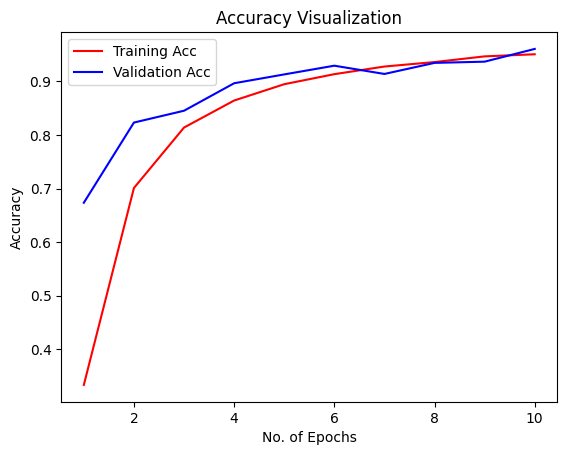

In [35]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history["accuracy"],color="red",label="Training Acc")
plt.plot(epochs,training_history.history["val_accuracy"],color="blue",label="Validation Acc")
plt.title("Accuracy Visualization")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig("AccuracyPlot/accuracy_plot2.png", dpi=300)
plt.show()

# Other means for Model Evaluation

In [47]:
valid_ds1= keras.utils.image_dataset_from_directory(
    "New Plant Diseases Dataset(Augmented)/valid",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [48]:
class_name = valid_ds1.class_names

In [57]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [58]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [59]:
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)

17572/17572 [==============================] - 88s 5ms/step


In [60]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [61]:
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [62]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [63]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [66]:
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.94      0.96       504
                                 Apple___Black_rot       0.98      0.96      0.97       497
                          Apple___Cedar_apple_rust       0.99      0.97      0.98       440
                                   Apple___healthy       0.96      0.92      0.94       502
                               Blueberry___healthy       0.96      0.97      0.97       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       421
                 Cherry_(including_sour)___healthy       1.00      0.93      0.96       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.82      0.89       410
                       Corn_(maize)___Common_rust_       0.96      1.00      0.98       477
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.97      0.

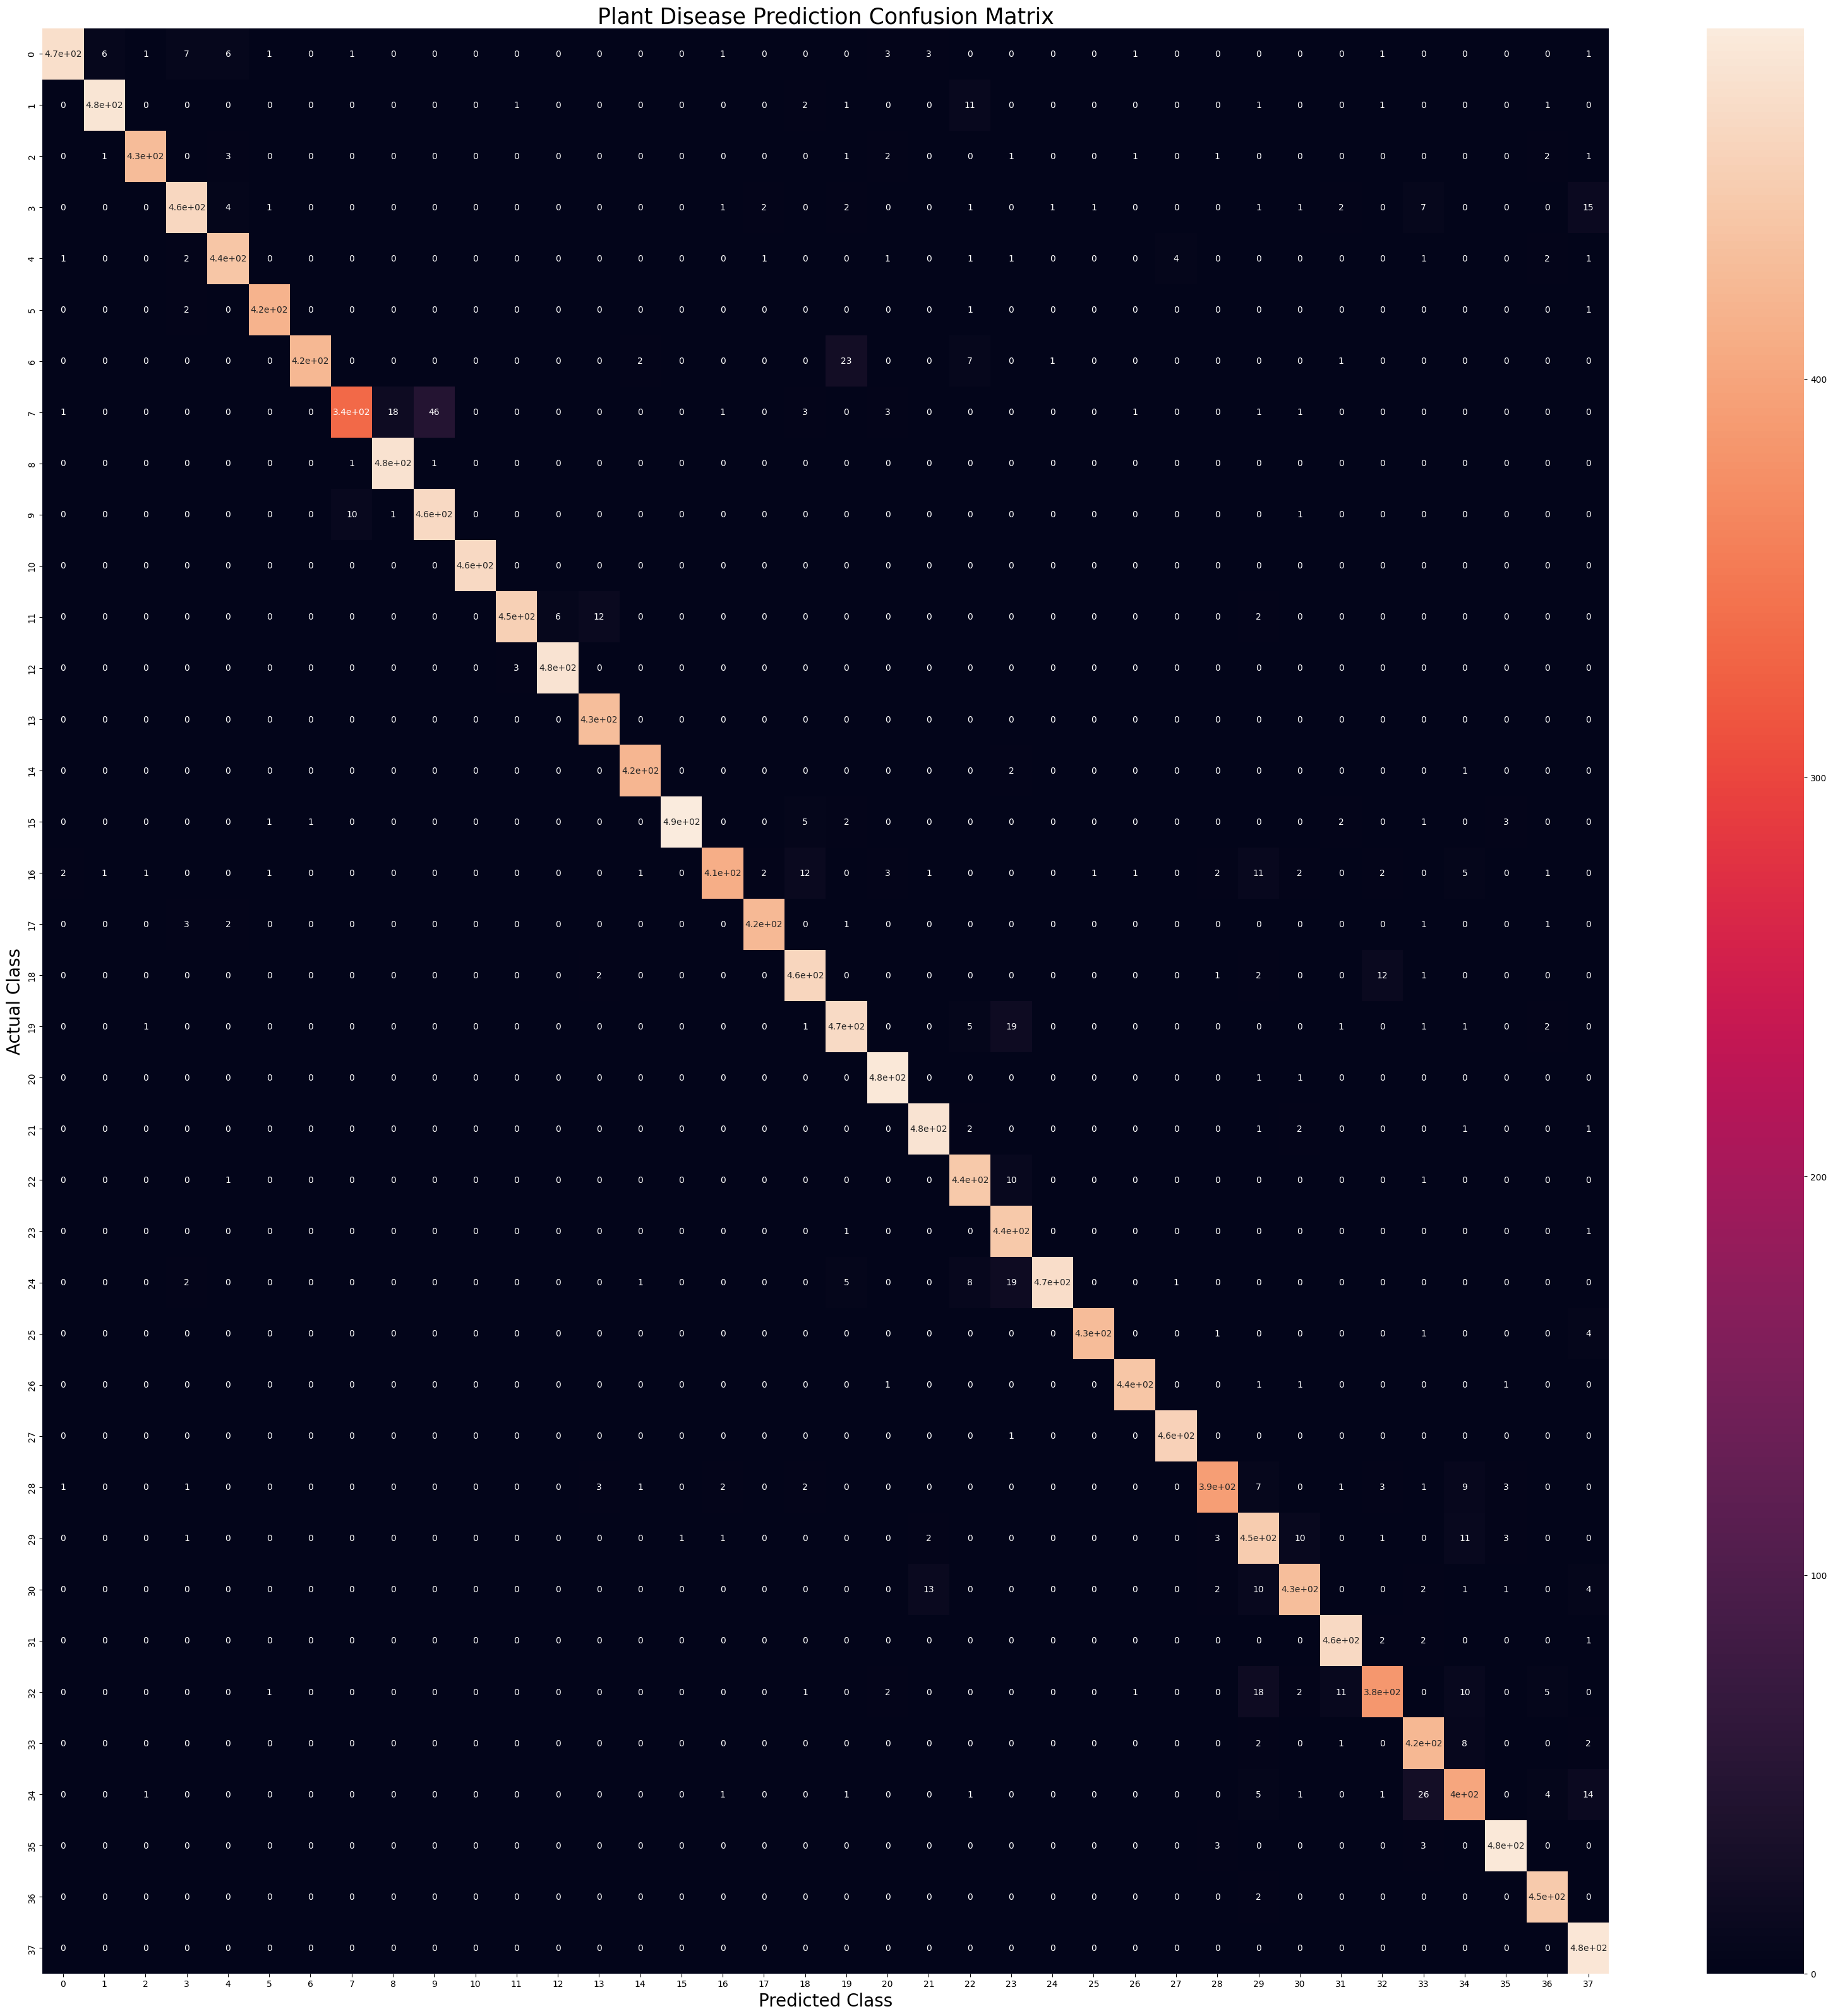

In [67]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.savefig('confusion_matrix.png')
plt.show()